In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import timedelta
import warnings
from preprocessing import get_consecutive
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")
from sklearn.preprocessing import KBinsDiscretizer


# Preprocesamiento de los datos

In [2]:
# abriendo datos
with open('./data/data_product_02.pk', 'rb') as f:
    data = pickle.load(f)
f.close()
data.head()

,wind_dir,wind_vel,rel_hum,precipitations,temp,mp_25
datetime,,,,,,
2014-03-24 14:00:00,210.0,3.550000,49.0,0.0,16.15,8.5
2014-03-24 16:00:00,211.5,4.150000,47.5,0.0,17.00,5.5
2014-03-24 18:00:00,243.5,3.500000,56.0,0.0,14.85,16.0
2014-03-24 20:00:00,269.5,1.600000,73.5,0.0,11.40,8.5
2014-03-24 22:00:00,300.5,0.799999,86.5,0.0,9.90,14.0


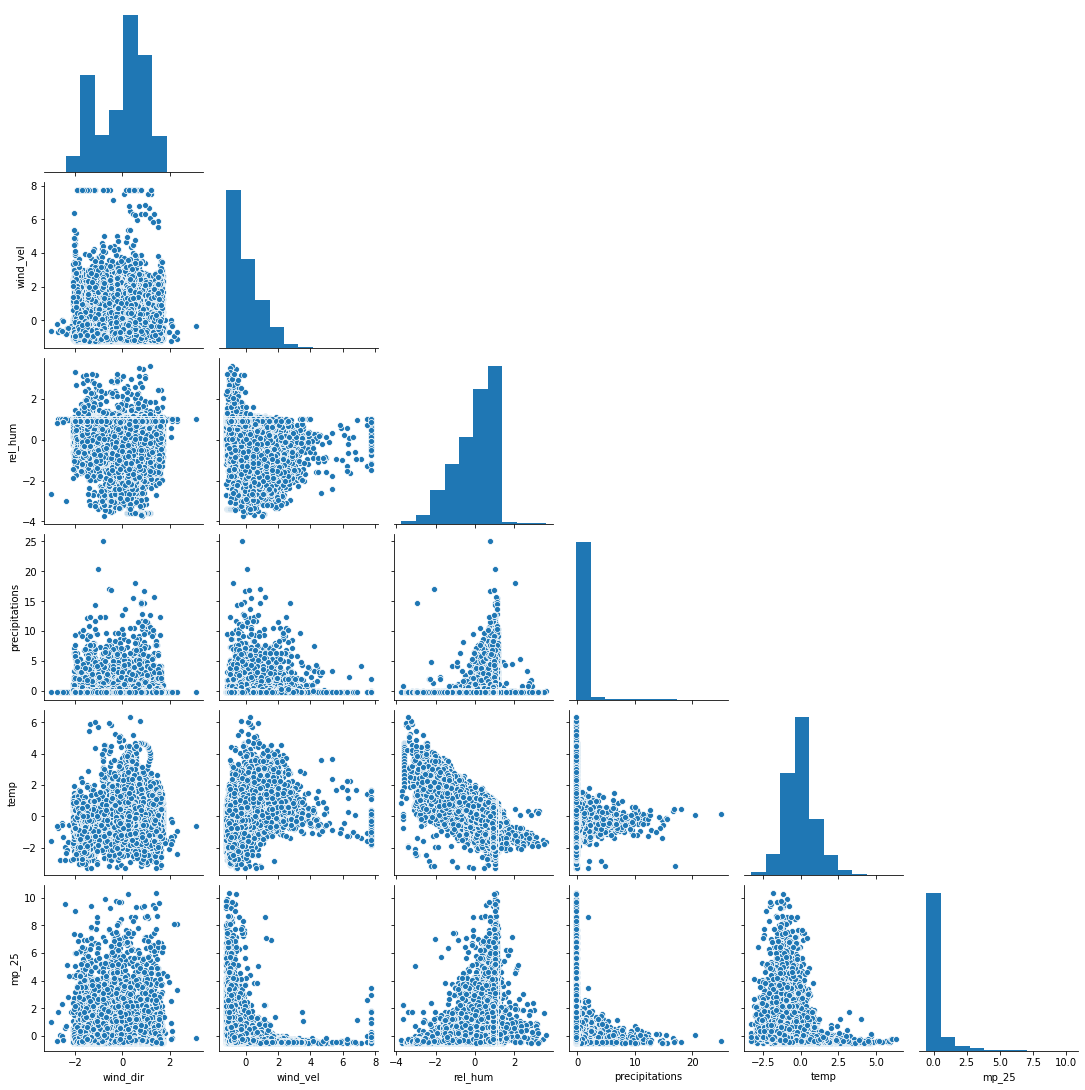

In [3]:
data_std = (data - data.mean())/data.std()
sb.pairplot(data_std, corner=True)

In [4]:
data_with_clusters = data_std.copy()
data_with_clusters['mp_25'] = data['mp_25']
for i in range(2, 11):
    kmeans = KMeans(i)
    kmeans.fit(data_with_clusters)
    data_with_clusters['{}_clusters'.format(i)] = kmeans.labels_
data_with_clusters.head()    

,wind_dir,wind_vel,rel_hum,precipitations,temp,mp_25,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,9_clusters,10_clusters
datetime,,,,,,,,,,,,,,,
2014-03-24 14:00:00,0.129948,1.434579,-1.733582,-0.207012,1.017230,8.5,0,1,0,0,0,0,0,0,0
2014-03-24 16:00:00,0.145960,1.881879,-1.811555,-0.207012,1.210544,5.5,0,1,0,0,0,0,0,0,0
2014-03-24 18:00:00,0.487556,1.397304,-1.369708,-0.207012,0.721575,16.0,0,1,0,0,0,0,0,0,0
2014-03-24 20:00:00,0.765102,-0.019146,-0.460023,-0.207012,-0.063050,8.5,0,1,0,0,0,0,0,0,0
2014-03-24 22:00:00,1.096023,-0.615547,0.215742,-0.207012,-0.404191,14.0,0,1,0,0,0,0,0,0,0


# Creando feature vectors

In [5]:
discretizador = KBinsDiscretizer(10)
mp_25_vectors = discretizador.fit_transform(data[['mp_25']]).toarray()

In [6]:
X, y = get_consecutive(data_with_clusters, 100)

In [7]:
for i, x in enumerate(X):
    yy = discretizador.transform(x[['mp_25']]).toarray()
    x.drop('mp_25', axis=1, inplace=True)
    for j in range(10):
        x['onehot_{}'.format(j)] = yy[:, j]
        

In [8]:
y = [discretizador.transform(i.mp_25.reshape(-1, 1)).toarray() for i in y]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Parte con Torch

In [25]:
class MP25Dataset(Dataset):
    """Dataset para el proyecto"""
    def __init__(self, X, y):
        self.X = [torch.from_numpy(x.values.reshape(-1)).float() for x in X]
        self.y = [torch.from_numpy(i).float() for i in y]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx], self.y[idx]
        return sample
    def __repr__(self):
        return 'MP25Dataset'

In [26]:
train_set = MP25Dataset(X_train, y_train)
test_set = MP25Dataset(X_test, y_test)

In [27]:
class Net(nn.Module):
    def __init__(self, N):
        super().__init__()
        assert type(N)==int
        self.N = N
        self.name = 'test'
        
        # FF
        self.fc1 = nn.Linear(N, int(N / 2))
        self.fc2 = nn.Linear(int(N / 2), 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [28]:
net = Net(len(X[0]))

In [29]:
net

Net(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [30]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
net = Net(len(train_set[0][0]))
net.to(device)

Net(
  (fc1): Linear(in_features=2400, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=10, bias=True)
)

In [32]:
loss_func = torch.nn.MSELoss().to(device)
opt = optim.Adam(net.parameters(), weight_decay=1)

In [33]:
def test(model, x_test, y_test, loss_function, batch_size=365*24):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x_i, y_i in zip(x_test, y_test):
            # predict data using the given model
            prediction = model(x_i)
            # Compute loss
            total_loss += loss_function(prediction, y_i).item()

    print(total_loss)

    return total_loss

def train(model, train_set, optimizer, loss_function, epochs=5, batch_size=365*24):
    model.train()
    total_loss = 0

    for i in range(epochs):
        # each epoch
        epoch_loss = 0
        best_test_loss = float('inf')

        
        for j in range(len(train_set)):
        # get the inputs; data is a list of [inputs, labels]
            x_i, y_i = train_set[j]

            x_i = x_i.to(device)
            y_i = y_i.to(device)
            optimizer.zero_grad()
            y_pred = model(x_i)

            loss = loss_function(y_pred, y_i)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Save results from the best trained model
        if epoch_loss < best_test_loss:
            best_test_loss = epoch_loss
            torch.save(model.state_dict(), '{}.pt'.format(model.name))
            
        total_loss += epoch_loss
        print(f'epoch: {i} loss: {epoch_loss:10.8f}')

    print(f'Average loss: {total_loss/len(train_set):4f}')
    return total_loss

In [34]:
train(net, train_set, opt, loss_func)

epoch: 0 loss: 1352.30928795
epoch: 1 loss: 1352.30977946
epoch: 2 loss: 1352.30948714
epoch: 3 loss: 1352.31052464
epoch: 4 loss: 1352.30927659
Average loss: 0.449990


6761.548355780542